In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

X_raw = pd.read_csv("../data/raw/genotypes.csv", index_col=0)
ph = pd.read_csv("../data/processed/phenotypes_clean.csv")

if "cultivar" in ph.columns:
    ph = ph.set_index("cultivar")
else:
    ph = ph.set_index(ph.columns[0])
    ph.index.name = "cultivar"

ph = ph.loc[X_raw.index]
y1 = ph["trait_y"].values

X_raw.shape, y1.shape


((300, 39000), (300,))

In [2]:
pipe_y = Pipeline([
    ("impute", SimpleImputer(strategy="mean")),
    ("scale", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

pipe_y.fit(X_raw.values, y1)
g_signal = pipe_y.predict(X_raw.values)  # genomic signal proxy
g_signal[:5]

array([-2.42238775, -1.16977507, -1.05261674, -0.84333936,  1.43000211])

In [3]:
rng = np.random.default_rng(42)

# Standardize genomic signal for clean control
g = (g_signal - g_signal.mean()) / g_signal.std()

# Choose noise levels (controls heritability-like behavior)
noise_y = rng.normal(0, 0.6, size=len(g))      # moderate noise
noise_dis = rng.normal(0, 0.8, size=len(g))    # noisier trait
noise_h = rng.normal(0, 0.7, size=len(g))      # moderate

# Trait definitions:
# - disease resistance: higher is better, negatively correlated with yield
trait_disease = (-0.6 * g) + noise_dis
# - height: mildly positively correlated with yield
trait_height = (0.3 * g) + noise_h

df_traits = pd.DataFrame({
    "cultivar": X_raw.index,
    "trait_y": y1,
    "trait_disease": trait_disease,
    "trait_height": trait_height
}).set_index("cultivar")

df_traits.corr()

,trait_y,trait_disease,trait_height
trait_y,1.000000,-0.568507,0.382133
trait_disease,-0.568507,1.000000,-0.318690
trait_height,0.382133,-0.318690,1.000000


In [4]:
def fit_predict_trait(X, y, alpha=1.0):
    pipe = Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler()),
        ("ridge", Ridge(alpha=alpha))
    ])
    pipe.fit(X, y)
    pred = pipe.predict(X)
    return pipe, pred

pipe_y, gebv_y = fit_predict_trait(X_raw.values, df_traits["trait_y"].values)
pipe_d, gebv_d = fit_predict_trait(X_raw.values, df_traits["trait_disease"].values)
pipe_h, gebv_h = fit_predict_trait(X_raw.values, df_traits["trait_height"].values)

gebv = pd.DataFrame({
    "cultivar": X_raw.index,
    "GEBV_yield": gebv_y,
    "GEBV_disease": gebv_d,
    "GEBV_height": gebv_h
}).set_index("cultivar")

gebv.head()

,GEBV_yield,GEBV_disease,GEBV_height
cultivar,,,
CULT_001,-2.422388,2.244673,-0.070639
CULT_002,-1.169775,-0.818088,-0.608750
CULT_003,-1.052617,1.057560,0.708826
CULT_004,-0.843339,0.027870,-0.584646
CULT_005,1.430002,-0.582078,-0.179112


In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
gebv_z = pd.DataFrame(
    sc.fit_transform(gebv),
    index=gebv.index,
    columns=[c + "_z" for c in gebv.columns]
)

w_y, w_d, w_h = 0.6, 0.3, -0.1

gebv_z["INDEX"] = (
    w_y * gebv_z["GEBV_yield_z"] +
    w_d * gebv_z["GEBV_disease_z"] +
    w_h * gebv_z["GEBV_height_z"]
)

ranking_index = gebv_z[["INDEX"]].sort_values("INDEX", ascending=False)
ranking_index.head(10)

,INDEX
cultivar,
CULT_013,1.235835
CULT_063,1.196377
CULT_050,1.006045
CULT_277,0.938127
CULT_144,0.928671
CULT_038,0.910750
CULT_065,0.904465
CULT_188,0.897768
CULT_076,0.897167


In [8]:
plot_df = pd.concat(
    [
        gebv_z[["GEBV_yield_z", "GEBV_disease_z", "GEBV_height_z", "INDEX"]],
    ],
    axis=1
).copy()

plot_df.head()


,GEBV_yield_z,GEBV_disease_z,GEBV_height_z,INDEX
cultivar,,,,
CULT_001,-1.438088,2.285810,-0.019780,-0.175132
CULT_002,-0.681630,-0.820623,-0.721325,-0.583032
CULT_003,-0.610877,1.081770,0.996422,-0.141637
CULT_004,-0.484493,0.037397,-0.689901,-0.210487
CULT_005,0.888388,-0.581248,-0.161198,0.374778


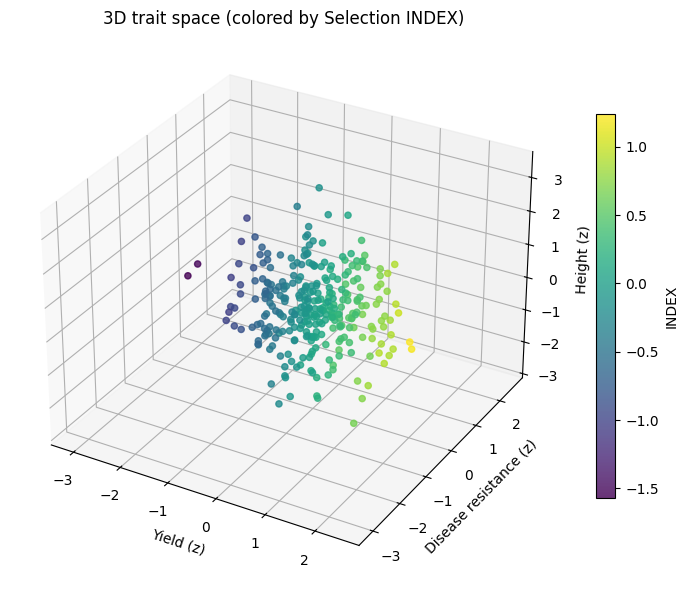

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    plot_df["GEBV_yield_z"],
    plot_df["GEBV_disease_z"],
    plot_df["GEBV_height_z"],
    c=plot_df["INDEX"],
    alpha=0.8
)

ax.set_xlabel("Yield (z)")
ax.set_ylabel("Disease resistance (z)")
ax.set_zlabel("Height (z)")
ax.set_title("3D trait space (colored by Selection INDEX)")
fig.colorbar(sc, ax=ax, shrink=0.7, label="INDEX")
plt.tight_layout()
plt.show()


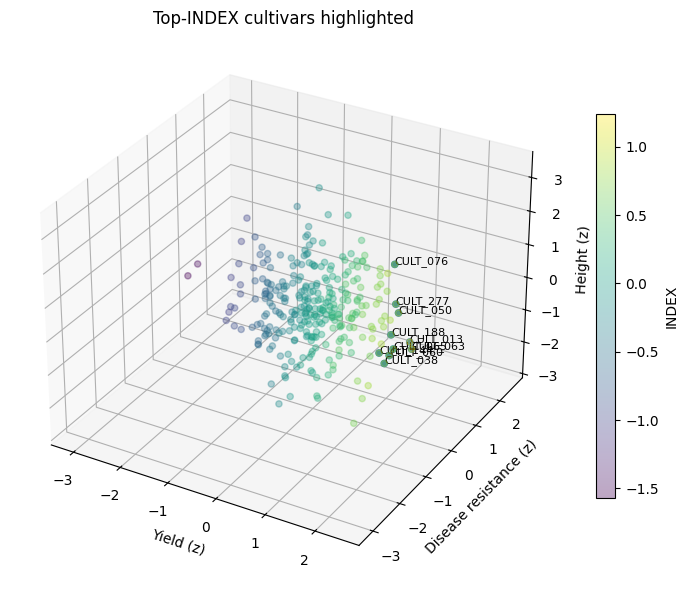

In [10]:
top10 = ranking_index.head(10).index.tolist()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    plot_df["GEBV_yield_z"],
    plot_df["GEBV_disease_z"],
    plot_df["GEBV_height_z"],
    c=plot_df["INDEX"],
    alpha=0.35
)

# Highlight top10
ax.scatter(
    plot_df.loc[top10, "GEBV_yield_z"],
    plot_df.loc[top10, "GEBV_disease_z"],
    plot_df.loc[top10, "GEBV_height_z"],
    alpha=1.0
)

for cv in top10:
    ax.text(
        plot_df.loc[cv, "GEBV_yield_z"],
        plot_df.loc[cv, "GEBV_disease_z"],
        plot_df.loc[cv, "GEBV_height_z"],
        cv,
        fontsize=8
    )

ax.set_xlabel("Yield (z)")
ax.set_ylabel("Disease resistance (z)")
ax.set_zlabel("Height (z)")
ax.set_title("Top-INDEX cultivars highlighted")
fig.colorbar(sc, ax=ax, shrink=0.7, label="INDEX")
plt.tight_layout()
plt.show()

In [6]:
top_yield = gebv_z.sort_values("GEBV_yield_z", ascending=False).head(10)
top_index = gebv_z.sort_values("INDEX", ascending=False).head(10)

top_yield[["GEBV_yield_z", "GEBV_disease_z", "GEBV_height_z", "INDEX"]], \
top_index[["GEBV_yield_z", "GEBV_disease_z", "GEBV_height_z", "INDEX"]]


(          GEBV_yield_z  GEBV_disease_z  GEBV_height_z     INDEX
 cultivar                                                       
 CULT_065      2.463322       -1.591337       0.961272  0.904465
 CULT_199      2.451423       -3.097974       1.967231  0.344738
 CULT_060      2.368703       -1.552021       0.703239  0.885292
 CULT_063      2.313192       -0.587302       0.153475  1.196377
 CULT_242      2.244295       -2.027005       0.982533  0.640222
 CULT_259      2.066883       -2.258395      -0.886953  0.651307
 CULT_188      2.059065       -0.894755       0.692445  0.897768
 CULT_210      2.004357       -0.833246       1.054468  0.847194
 CULT_299      1.985436       -1.003001       1.285837  0.761778
 CULT_038      1.949869       -0.924283      -0.181139  0.910750,
           GEBV_yield_z  GEBV_disease_z  GEBV_height_z     INDEX
 cultivar                                                       
 CULT_013      1.812974        0.320871      -0.517898  1.235835
 CULT_063      2.313192 

In [7]:
from pathlib import Path
Path("../outputs/tables").mkdir(parents=True, exist_ok=True)

ranking_index.reset_index().to_csv("../outputs/tables/day6_multitrait_index_ranking.csv", index=False)
print("Saved: ../outputs/tables/day6_multitrait_index_ranking.csv")

Saved: ../outputs/tables/day6_multitrait_index_ranking.csv


In [11]:
def simulate_progeny_dosage(gA, gB, n_offspring=1000, mode="F2", rng=42):
    rng = np.random.default_rng(rng)

    gA = np.asarray(gA, dtype=float)
    gB = np.asarray(gB, dtype=float)

    pA = np.clip(gA / 2.0, 0.0, 1.0)
    pB = np.clip(gB / 2.0, 0.0, 1.0)

    p = 0.5 * (pA + pB)
    p = np.nan_to_num(p, nan=0.5)

    mode = mode.upper()

    if mode == "F2":
        return rng.binomial(2, p, size=(n_offspring, len(gA)))
    if mode == "DH":
        H = rng.binomial(1, p, size=(n_offspring, len(gA)))
        return 2 * H

    raise ValueError("mode must be 'F2' or 'DH'")


In [12]:
def compute_index_from_preds(pred_y, pred_d, pred_h, w_y=0.6, w_d=0.3, w_h=-0.1):
    # z-score within the vector
    def z(v):
        v = np.asarray(v)
        return (v - v.mean()) / (v.std(ddof=1) + 1e-12)

    zy = z(pred_y)
    zd = z(pred_d)
    zh = z(pred_h)

    return w_y*zy + w_d*zd + w_h*zh


def cross_index_metrics(a, b, X_raw, pipe_y, pipe_d, pipe_h,
                        n=1000, mode="F2", rng=42,
                        w_y=0.6, w_d=0.3, w_h=-0.1):
    gA = X_raw.loc[a].values
    gB = X_raw.loc[b].values

    G = simulate_progeny_dosage(gA, gB, n_offspring=n, mode=mode, rng=rng)

    pred_y = pipe_y.predict(G)
    pred_d = pipe_d.predict(G)
    pred_h = pipe_h.predict(G)

    idx = compute_index_from_preds(pred_y, pred_d, pred_h, w_y=w_y, w_d=w_d, w_h=w_h)

    return {
        "cross": f"{a} x {b}",
        "mode": mode,
        "mean_INDEX": float(idx.mean()),
        "sd_INDEX": float(idx.std(ddof=1)),
        "p95_INDEX": float(np.percentile(idx, 95)),
    }


In [13]:
top_parents_index = ranking_index.head(10).index.tolist()

rows = []
for i in range(len(top_parents_index)):
    for j in range(i+1, len(top_parents_index)):
        a = top_parents_index[i]
        b = top_parents_index[j]
        rows.append(
            cross_index_metrics(a, b, X_raw, pipe_y, pipe_d, pipe_h,
                               n=1200, mode="F2", rng=42,
                               w_y=w_y, w_d=w_d, w_h=w_h)
        )

cross_index = pd.DataFrame(rows)

# Add a breeder-style risk preference score
k = 1.0
cross_index["index_score"] = cross_index["mean_INDEX"] + k * cross_index["sd_INDEX"]

cross_index_sorted = cross_index.sort_values(["p95_INDEX", "index_score"], ascending=False).reset_index(drop=True)
cross_index_sorted.head(10)


,cross,mode,mean_INDEX,sd_INDEX,p95_INDEX,index_score
0,CULT_013 x CULT_050,F2,-4.418688e-16,0.493068,0.838385,0.493068
1,CULT_065 x CULT_076,F2,8.548717e-16,0.492651,0.836583,0.492651
2,CULT_063 x CULT_050,F2,2.501703e-16,0.482667,0.829161,0.482667
3,CULT_188 x CULT_076,F2,-2.401782e-16,0.485827,0.828090,0.485827
4,CULT_063 x CULT_188,F2,-8.393286e-16,0.484543,0.825987,0.484543
5,CULT_013 x CULT_144,F2,-1.122065e-15,0.491311,0.822909,0.491311
6,CULT_277 x CULT_076,F2,-8.815171e-16,0.486433,0.821072,0.486433
7,CULT_144 x CULT_060,F2,-6.283862e-16,0.487844,0.816450,0.487844
8,CULT_277 x CULT_188,F2,-3.789561e-16,0.485477,0.814943,0.485477
9,CULT_144 x CULT_038,F2,9.784766e-16,0.482259,0.813507,0.482259


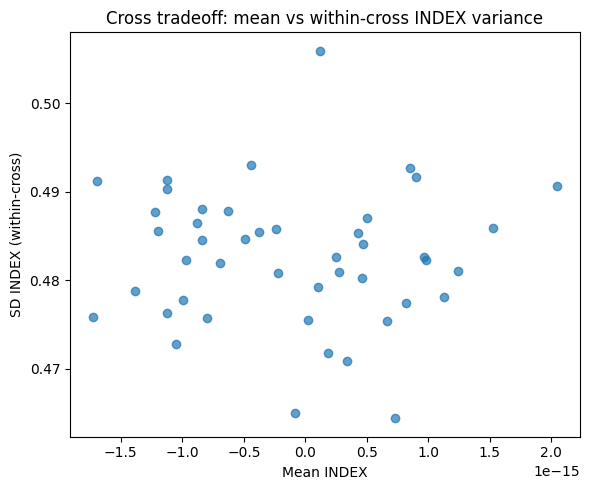

In [14]:
plt.figure(figsize=(6,5))
plt.scatter(cross_index["mean_INDEX"], cross_index["sd_INDEX"], alpha=0.7)
plt.xlabel("Mean INDEX")
plt.ylabel("SD INDEX (within-cross)")
plt.title("Cross tradeoff: mean vs within-cross INDEX variance")
plt.tight_layout()
plt.show()

In [15]:
from pathlib import Path
Path("../outputs/tables").mkdir(parents=True, exist_ok=True)

cross_index_sorted.to_csv("../outputs/tables/day7_multitrait_index_cross_ranking.csv", index=False)
print("Saved: ../outputs/tables/day7_multitrait_index_cross_ranking.csv")


Saved: ../outputs/tables/day7_multitrait_index_cross_ranking.csv


In [16]:
panel_stats = {}

for trait, gebv_col in zip(
    ["yield", "disease", "height"],
    ["GEBV_yield", "GEBV_disease", "GEBV_height"]
):
    panel_stats[trait] = {
        "mean": gebv[gebv_col].mean(),
        "sd": gebv[gebv_col].std(ddof=1)
    }

panel_stats


{'yield': {'mean': np.float64(-0.041071418776020455),
  'sd': np.float64(1.6586568239974653)},
 'disease': {'mean': np.float64(-0.009001470341020253),
  'sd': np.float64(0.9875886079242483)},
 'height': {'mean': np.float64(-0.05546674623405212),
  'sd': np.float64(0.7683189358063803)}}

In [17]:
def compute_index_panel_standardized(pred_y, pred_d, pred_h,
                                     panel_stats,
                                     w_y=0.6, w_d=0.3, w_h=-0.1):

    zy = (pred_y - panel_stats["yield"]["mean"]) / panel_stats["yield"]["sd"]
    zd = (pred_d - panel_stats["disease"]["mean"]) / panel_stats["disease"]["sd"]
    zh = (pred_h - panel_stats["height"]["mean"]) / panel_stats["height"]["sd"]

    return w_y*zy + w_d*zd + w_h*zh


In [18]:
def cross_index_metrics_panel(a, b, X_raw, pipe_y, pipe_d, pipe_h,
                              panel_stats,
                              n=1200, mode="F2", rng=42):

    gA = X_raw.loc[a].values
    gB = X_raw.loc[b].values

    G = simulate_progeny_dosage(gA, gB, n_offspring=n, mode=mode, rng=rng)

    pred_y = pipe_y.predict(G)
    pred_d = pipe_d.predict(G)
    pred_h = pipe_h.predict(G)

    idx = compute_index_panel_standardized(
        pred_y, pred_d, pred_h,
        panel_stats
    )

    return {
        "cross": f"{a} x {b}",
        "mode": mode,
        "mean_INDEX": idx.mean(),
        "sd_INDEX": idx.std(ddof=1),
        "p95_INDEX": np.percentile(idx, 95),
    }


rows = []
for i in range(len(top_parents_index)):
    for j in range(i+1, len(top_parents_index)):
        a = top_parents_index[i]
        b = top_parents_index[j]
        rows.append(
            cross_index_metrics_panel(
                a, b, X_raw,
                pipe_y, pipe_d, pipe_h,
                panel_stats,
                n=1200, mode="F2", rng=42
            )
        )

cross_index_prod = pd.DataFrame(rows)
cross_index_prod["index_score"] = cross_index_prod["mean_INDEX"] + cross_index_prod["sd_INDEX"]

cross_index_prod.sort_values("p95_INDEX", ascending=False).head(10)


,cross,mode,mean_INDEX,sd_INDEX,p95_INDEX,index_score
0,CULT_013 x CULT_063,F2,1.140626,0.040485,1.206273,1.181111
1,CULT_013 x CULT_050,F2,1.068425,0.041372,1.139227,1.109797
3,CULT_013 x CULT_144,F2,1.039108,0.040892,1.107344,1.080000
2,CULT_013 x CULT_277,F2,1.038700,0.039729,1.105267,1.078429
6,CULT_013 x CULT_188,F2,1.034471,0.040176,1.101713,1.074648
9,CULT_063 x CULT_050,F2,1.026609,0.040759,1.096604,1.067368
5,CULT_013 x CULT_065,F2,1.023320,0.041207,1.090778,1.064527
8,CULT_013 x CULT_060,F2,1.021340,0.039916,1.087828,1.061256
7,CULT_013 x CULT_076,F2,1.019988,0.040152,1.084918,1.060139
10,CULT_063 x CULT_277,F2,1.008835,0.040022,1.074650,1.048857


In [19]:
cross_index_prod.to_csv(
    "../outputs/tables/day7_multitrait_index_cross_ranking_PRODUCTION.csv",
    index=False
)

print("Saved: production-grade multi-trait cross ranking")


Saved: production-grade multi-trait cross ranking
